In [1]:
import pandas as pd
import janitor
import forestplot as fp
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from typing import Iterable, Optional


def save_mpl_fig(
    savepath: str, formats: Optional[Iterable[str]] = None, dpi: Optional[int] = None
) -> None:
    """Save matplotlib figures to ../output.

    Will handle saving in png and in pdf automatically using the same file stem.

    Parameters
    ----------
    savepath: str
        Name of file to save to. No extensions.
    formats: Array-like
        List containing formats to save in. (By default 'png' and 'pdf' are saved).
        Do a:
            plt.gcf().canvas.get_supported_filetypes()
        or:
            plt.gcf().canvas.get_supported_filetypes_grouped()
        To see the Matplotlib-supported file formats to save in.
        (Source: https://stackoverflow.com/a/15007393)
    dpi: int
        DPI for saving in png.

    Returns
    -------
    None
    """
    # Save pdf
    plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)

    # save png
    plt.savefig(f"{savepath}.png", dpi=dpi, bbox_inches="tight", pad_inches=0)

    # Save additional file formats, if specified
    if formats:
        for format in formats:
            plt.savefig(
                f"{savepath}.{format}",
                dpi=None,
                bbox_inches="tight",
                pad_inches=0,
            )
    return None


# ============================================================================
fp_estimates = "./data/pfas-tf-spresto.dta"
fp_completeness = "./data/pfas-plasma-spresto-completeness-tabulation.csv"

# ============================================================================
pfas = [
    "pfhxs",
    "pfos_linear",
    "pfos_branched",
    "pfoa_linear",
    "pfna",
    "pfhps",
    "pfda",
    "pfhpa",
]

In [2]:
df = (
    pd.read_stata(fp_estimates)
    # ====================================================================
    # Convert the specs into a single column for the pfas name
    .fillna(0)
    .assign(pfas=lambda df_: pd.from_dummies(df_[pfas]))
    .remove_columns(pfas)
    # ==================================================================
    # Get LOD/LOQ values
    .merge(
        pd.read_csv(fp_completeness),
        how="left",
        on="pfas",
        validate="1:1",
    )
    # ========================================================================
    # Format cell values for alignment
    # Pad the measured column
    .assign(measured=lambda df_: df_["measured"].apply(str).str.pad(len("  n")))
    # Pad the measured, < LOD, < LOQ columns
    # So that they are padded to the left
    .assign(
        **{
            k: lambda df_, col=k: df_[col].apply(str).str.pad(len("< loq"), side="left")
            for k in [
                "LOD",
            ]
        }
    )
)
df.to_csv("./data/coefplot-pfas-transport-facilities-spresto.csv", index=False)

df

,spec_id,beta,se,u95,l95,u90,l90,tstat,pval,pfas,full_analyte_name,measured,LOD,lod,analyte_code
0,1,0.037641,0.028735,0.096707,-0.021425,0.086652,-0.011370,1.309918,0.201680,pfhxs,Perfluorohexane-1-sulphonic acid,384,0,0.1 ng/ml,PFHxS
1,2,0.100438,0.036260,0.174972,0.025904,0.162284,0.038592,2.769913,0.010210,pfos_linear,Perfluorooctanesulfonic acid,384,0,0.2 ng/ml,PFOS-Linear
2,3,0.060809,0.048054,0.159585,-0.037966,0.142770,-0.021152,1.265447,0.216934,pfos_branched,Perfluorooctanesulfonic acid,383,1,0.2 ng/ml,PFOS-Branched
3,4,0.028034,0.038112,0.106373,-0.050306,0.093037,-0.036970,0.735564,0.468580,pfoa_linear,Perfluorooctanoic acid,374,10,0.5 ng/ml,PFOA-Linear
4,5,0.112265,0.048349,0.211647,0.012883,0.194729,0.029801,2.321987,0.028332,pfna,Perfluorononanoic acid,233,151,0.5 ng/ml,PFNA
5,6,0.096993,0.040615,0.180478,0.013508,0.166266,0.027720,2.388130,0.024488,pfhps,Perfluoroheptanesulfonic acid,186,198,0.2 ng/ml,PFHpS
6,7,0.031146,0.021860,0.076079,-0.013787,0.068430,-0.006138,1.424831,0.166100,pfda,Perfluorodecanoic acid,159,225,0.5 ng/ml,PFDA
7,8,0.123796,0.039025,0.204013,0.043578,0.190358,0.057233,3.172186,0.003860,pfhpa,Perluoroheptanoic acid,130,254,0.2 ng/ml,PFHpA


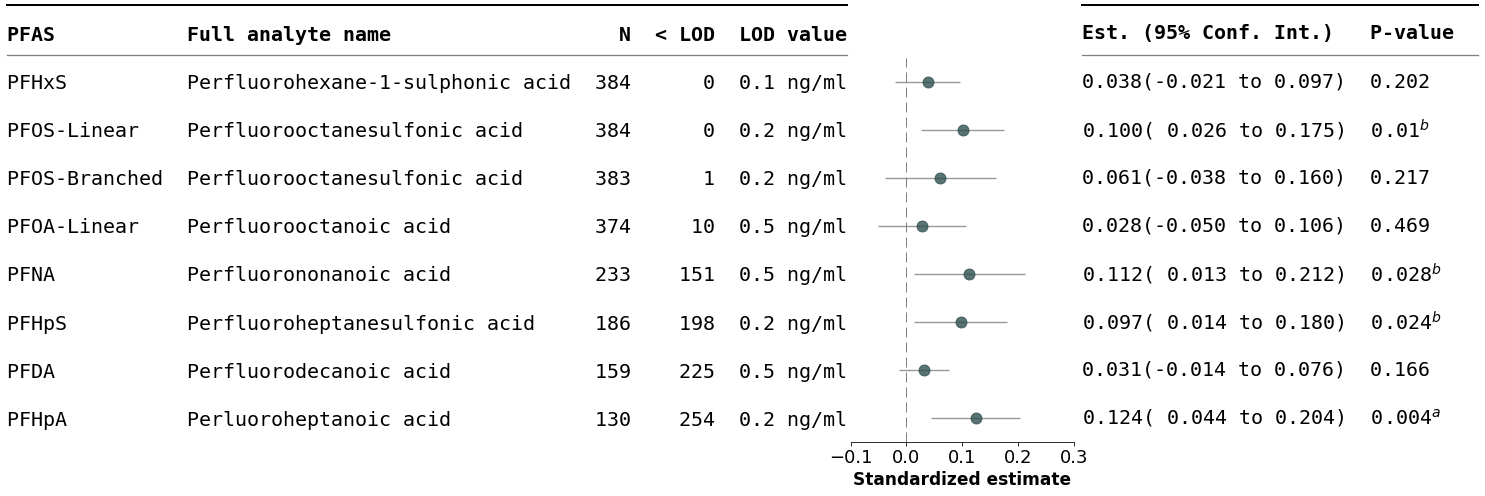

In [3]:
_opts = dict(
    estimate="beta",
    ll="l95",
    hl="u95",
    varlabel="analyte_code",
    pval="pval",
    annote=["full_analyte_name", "measured", "LOD", "lod"],
    annoteheaders=[
        "Full analyte name",
        "  N",
        "< LOD",
        "LOD value",
    ],
    rightannote=["est_ci", "formatted_pval"],
    right_annoteheaders=["Est. (95% Conf. Int.)", "P-value"],
    table=True,
    variable_header="PFAS",
    decimal_precision=3,
    xlabel="Standardized estimate",
    xlabel_size=17,    xticks=[-0.1, 0, 0.1, 0.2, 0.3],
    symbols=["$^a$", "$^b$", "$^c$"],
    **{
        "marker": "o",  # set maker symbol as diamond
        "markersize": 120,  # adjust marker size
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": "#808080",  # gray color for x-reference line
        "xtick_size": 18,  # adjust x-ticker fontsize
        "fontsize": 20,
    },
)

fp.forestplot(
    df.query("pfas in @pfas"),
    **_opts,
)
save_mpl_fig("./figures/coefplot-8pfas-transport-facilities-spresto")